### Importing dependencies for the project

In [2]:
import zipfile as zipfile
import numpy as np
import tensorflow as tf
import rasterio as rio
import matplotlib as mpl
import visualkeras
import io
import os

import matplotlib.pyplot as plt

### Global constants

In [3]:
RANDOM_STATE = 18022026
DATA_PATH = "Potsdam-GeoTif.zip"  # Path to the zipped data

# Step 1 - Dataset preparation

## Step 1.1 - Loading the data
In this step we will load the filename data from the zipped dataset into a pandas dataframe.

In [4]:
import zipfile
import pandas as pd

# Read the name of the files in the potsdam dataset and log them
# to a pandas df that we then can use to create splits of the data
with zipfile.ZipFile(DATA_PATH, "r") as z:
    file_paths = z.namelist()

# Remove the first entry and remove all prefixes
file_paths = sorted([fp for fp in file_paths[1:]])

# Create the pandas DF
file_path_df = pd.DataFrame({
    "file_path" : file_paths
})

# Display the DF
display(file_path_df.head())

,file_path
0,Potsdam-GeoTif/0000000224-0000028448.tif
1,Potsdam-GeoTif/0000000224-0000028672.tif
2,Potsdam-GeoTif/0000000224-0000028896.tif
3,Potsdam-GeoTif/0000000224-0000029120.tif
4,Potsdam-GeoTif/0000000224-0000029344.tif


## Step 1.2 - Create the 5 splits
In this step we will create a small splitter function for the dataset of indices in order to perform a split on the image dataset.

In [5]:
# The splitter
def df_splitter(df: pd.DataFrame, n, random_state):
    # Get the indices pf the dataframe
    indices = df.index.to_numpy(copy=True)
    # Shuffle them to ensure that the order does not matter    
    np.random.seed(random_state)
    np.random.shuffle(indices)
    # This function splits the array into n roughlt equal parts
    # this much nicer to use than the regular split which needs
    # the array to be divisible by n
    splits = np.array_split(indices, n)
    return splits

cv_splits = df_splitter(file_path_df,5,RANDOM_STATE)

# Step 1.3 - Looking at a sample image
In this step we will take a look at one sample image and display its different bands. The colorbar used in the images is automatically scaled to the values in the multi dimensional image array that it displays.The values in the 

--- Brief look at some samples of image data ---


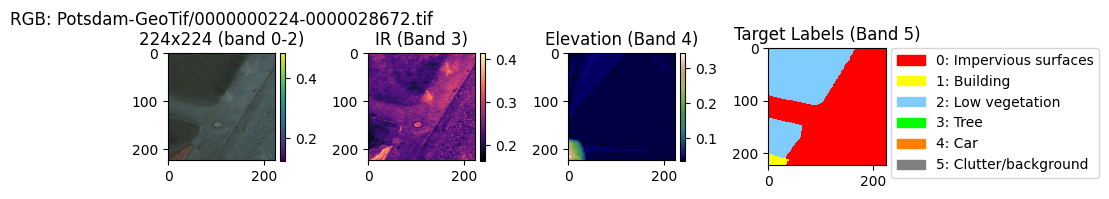

Path of sampled image:  Potsdam-GeoTif/0000000224-0000028672.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xd5\x8d\xd8\xe5\x8e\xd8\xf2\xa7\x88\x08'


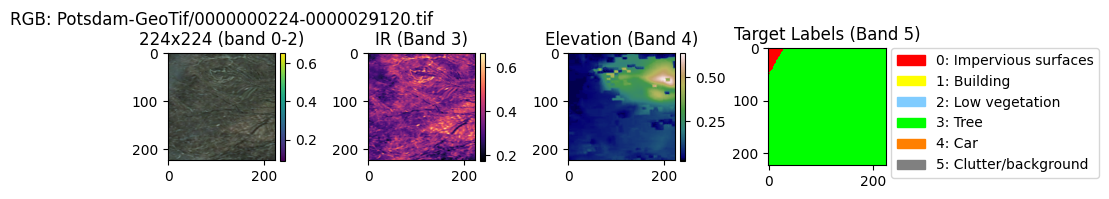

Path of sampled image:  Potsdam-GeoTif/0000000224-0000029120.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xe7\xa4\xf5\x9e\xd3\xde|Gb\x02'


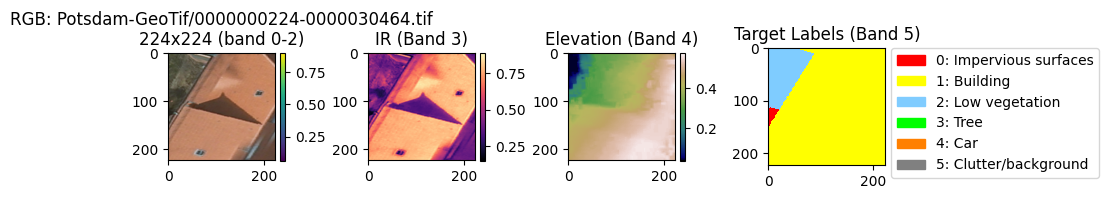

Path of sampled image:  Potsdam-GeoTif/0000000224-0000030464.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xf6\xc6\xd9\xdb[one\xc2\x02'


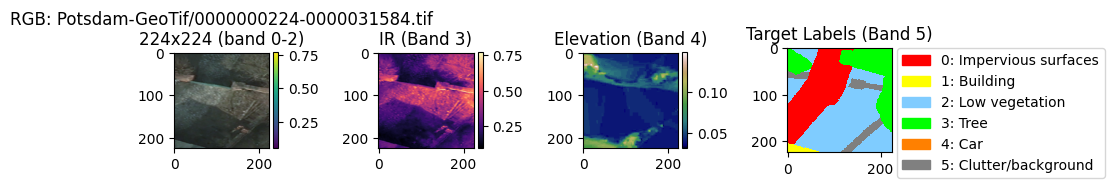

Path of sampled image:  Potsdam-GeoTif/0000000224-0000031584.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xaf\x95\xf6\xbfW\xfb\x01@\x08\x08'


In [6]:
def extract_img_data_as_ndarray(path):
    # Code frome the Visualize_GeoTiff.ipynb notebook given in the assignment.
    img = rio.open(path)
    img_array = img.read()
    nRows = img_array.shape[1]
    nCols = img_array.shape[2]
    bands = img_array.shape[0]
    img_array = img_array.reshape(bands, nRows * nCols).T
    img_array = img_array.reshape(nRows, nCols, bands)
    # Pulling out different channels from the image and scaling the data.
    rgb_img_array = img_array[:, :, 0:3] / 255
    elevation_img_array = img_array[:, :, 3:4] / 255
    water_mask_img_array = img_array[:, :, 4:5] / 255
    target_label_img_array = img_array[:, :, 5:]
    return (rgb_img_array, elevation_img_array, water_mask_img_array, target_label_img_array, nRows, nCols)

# A function that reads in data from a path and plots it using subplots.
def display_tif(path, title):
    rgb_img_array, elevation_img_array, water_mask_img_array, target_label_img_array, nRows, nCols = extract_img_data_as_ndarray(path)
    # Plotting the data.
    _, axes = plt.subplots(1, 4, figsize=(10, 3))
    
    # Plot 1: RGB Image plot
    im1 = axes[0].imshow(rgb_img_array)
    axes[0].set_title(f"RGB: {title}\n{nRows}x{nCols} (band 0-2)")
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Plot 2: IR plot
    im2 = axes[1].imshow(elevation_img_array, cmap="magma")
    axes[1].set_title("IR (Band 3)")
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot 3: Elevation plot
    im3 = axes[2].imshow(water_mask_img_array, cmap="gist_earth")
    axes[2].set_title("Elevation (Band 4)")
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    # Plot 4: Target Labels, for this we also need to create a custom colormap
    class_names = [
        "Impervious surfaces", 
        "Building", 
        "Low vegetation", 
        "Tree", 
        "Car", 
        "Clutter/background"
    ]

    # Class Colors (Normalized RGB 0-1)
    class_colors = [
        (1.0, 0.0, 0.0),  # 0: Impervious surfaces (Red)
        (1.0, 1.0, 0.0),  # 1: Building (Yellow)
        (0.5, 0.8, 1.0),  # 2: Low vegetation (Baby blue)
        (0.0, 1.0, 0.0),  # 3: Tree (Green)
        (1.0, 0.5, 0.0),  # 4: Car (Orange)
        (0.5, 0.5, 0.5)   # 5: Clutter/background (Gray)
    ]

    # Create the colormap
    cmap = mpl.colors.ListedColormap(class_colors)

    # Create boundaries, these ensures that the classes get the the correct colors
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # Display the image
    axes[3].imshow(target_label_img_array, cmap=cmap, norm=norm, interpolation='nearest')
    axes[3].set_title("Target Labels (Band 5)")
    
    # Create legend patches
    patches = [
        mpl.patches.Patch(color=class_colors[i], label=f"{i}: {class_names[i]}") 
        for i in range(len(class_names))
    ]
    
    # Add legend outside the plot
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

# Lets first look at the data from a samples image.
print("--- Brief look at some samples of image data ---")
with zipfile.ZipFile(DATA_PATH, "r") as z:
    for i in [2,4,10,15]:
        sample_image_path = z.namelist()[i]
        with z.open(sample_image_path) as f:
            display_tif(f, sample_image_path)
            print("Path of sampled image: ", sample_image_path)
            img = rio.open(f)
            img_array = img.read()[0:5]
            # Set some print options ot not bloat the terminal output
            print("Array representation of raw image data: ", img_array.shape)
            raw_data = f.read()
            print("Byte string of raw image data: ", raw_data[0:10], "...", raw_data[-10:])

## Step 1.4 - Create TFRecord files
In this step we will create 5 TFRecord files and output them to the dir of this notebook.

In [7]:
# A function that turns the tif images into Example
# objects that can be serialized and written into the TFRecords file. Example is kind of
# unconvential name for something that is really just a row, sample or record.
def create_example(raw_tif_data, file_path):
    feature = {
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[raw_tif_data])),
        "filename": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[file_path.encode("utf-8")])
        ),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

# Open the zipfile
print("\n--- Starting writing the splits to TFRecords ---")
with zipfile.ZipFile(DATA_PATH, "r") as z:
    # Iterate over every split
    for i, indices in enumerate(cv_splits):
        print(f"Processing split {i}")

        filename = f"Potsdam-GeoTif-split-{i}.tfrecords"
        if (os.path.exists(filename)):
            print(f"File: {filename} already exists")
            continue
        
        file_paths = file_path_df.iloc[indices]["file_path"].to_list()
        # Create a list of tuples (raw, filename)
        print(f"Extracting raw image information for split {i}")
        image_data = [(z.open(path).read(), path) for path in file_paths]
        # Create a TF records writer
        print(f"Writing raw image data to tfrecords for split {i}")
        with tf.io.TFRecordWriter(f"Potsdam-GeoTif-split-{i}.tfrecords") as writer:
            for raw_tif_data, file_path in image_data:
                example = create_example(raw_tif_data, file_path)
                serialized = example.SerializeToString()
                writer.write(serialized)


--- Starting writing the splits to TFRecords ---
Processing split 0
File: Potsdam-GeoTif-split-0.tfrecords already exists
Processing split 1
File: Potsdam-GeoTif-split-1.tfrecords already exists
Processing split 2
File: Potsdam-GeoTif-split-2.tfrecords already exists
Processing split 3
File: Potsdam-GeoTif-split-3.tfrecords already exists
Processing split 4
File: Potsdam-GeoTif-split-4.tfrecords already exists


## Step 2

### Step 2.1 Setup Dataset for Training
In this step we define feature descriptions and channel configurations for the TensorFlow framework. The descriptions tells the model and training algorithms how to handle the different features. Channel config defines different configurations that can be used which makes it possible to train models with or without IR channels or elevation channels.

In [8]:
FEATURE_DESCRIPTION = {
    "image":    tf.io.FixedLenFeature([], tf.string),  # raw .tif bytes
    "filename": tf.io.FixedLenFeature([], tf.string),  # path string
}

CHANNEL_CONFIG = {
    "rgb":              [0, 1, 2],
    "rgb_ir":           [0, 1, 2, 3],
    "rgb_elevation":    [0, 1, 2, 4],
    "all_features":     [0, 1, 2, 3, 4],
}

# Change this one line to switch configurations
SELECTED_CHANNELS = CHANNEL_CONFIG["rgb_ir"]
NUM_CHANNELS      = len(SELECTED_CHANNELS)
NUM_CLASSES       = 6

In [9]:
def decode_tif_bytes(raw_bytes: bytes, channel_indices: list):
    # Use rio to extraxt the raw bytes as a ndarray
    with rio.open(io.BytesIO(raw_bytes)) as src:
        img_array = src.read() # shape: (bands, H, W)

    # Transform the array into TF compatible Height, Width, channels/bands
    img_array = np.transpose(img_array, (1, 2, 0)).astype(np.float32)  # (H, W, bands)

    # Select only the desired feature channels
    features = img_array[:, :, channel_indices] / 255.0

    # Label band is always index 5, independent of channel selection
    labels = img_array[:, :, 5:6].astype(np.int32)

    return features, labels

def parse_and_decode(serialized_example):
    parsed = tf.io.parse_single_example(serialized_example, FEATURE_DESCRIPTION)

    def decode_wrapper(raw):
        features, labels = decode_tif_bytes(raw.numpy(), SELECTED_CHANNELS)
        return features, labels

    features, labels = tf.py_function(
        func=decode_wrapper,
        inp=[parsed["image"]],
        Tout=[tf.float32, tf.int32],
    )

    features.set_shape([224, 224, NUM_CHANNELS])
    labels.set_shape([224, 224, 1])

    return features, labels

### Step 2.1.1 Augmentation
In this step we create an augmentation function that augments the features of the dataset in order to facilitate better model learning. This function takes in images (or more specifically image data) and randomly modifies their orientation, brightness and contrast levels in order to force the model to learn invariant properties of the targets. For example we want the model to learn the shape of a car, not the shape of a car that is parked with the front facing north.

In [10]:
def augment(features, labels):
    # Cast labels to floats from ints and combine the label matrix with the feature matrix temporarily
    labels_float = tf.cast(labels, tf.float32)
    combined = tf.concat([features, labels_float], axis=-1)

    # Rotate the image randomly, this is to force the model to learn invariant features like the shape of a car
    # no matter the orientation of the car.
    combined = tf.image.random_flip_left_right(combined)
    combined = tf.image.random_flip_up_down(combined)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    combined = tf.image.rot90(combined, k=k)

    # Separate the feature and label matrices again
    features = combined[:, :, :NUM_CHANNELS]
    labels   = tf.cast(combined[:, :, NUM_CHANNELS:], tf.int32)

    # Only apply photometric augmentation if RGB channels are present
    # We check whether any of the RGB band indices appear in the selection
    rgb_bands_in_selection = [i for i, ch in enumerate(SELECTED_CHANNELS) if ch in [0, 1, 2]]

    if len(rgb_bands_in_selection) == 3:
        # Randomly add contrast and brighntess to force the model to learn invariant shape properties
        rgb = tf.stack([features[:, :, i] for i in rgb_bands_in_selection], axis=-1)
        rgb = tf.image.random_brightness(rgb, max_delta=0.15)
        rgb = tf.image.random_contrast(rgb, lower=0.8, upper=1.2)
        rgb = tf.clip_by_value(rgb, 0.0, 1.0)

        # Write the augmented RGB values back into the correct channel positions
        # This is necessary because the RGB channels might not be contiguous
        # if you ever build a config like [elevation, rgb] i.e. [3, 0, 1, 2]
        channels = tf.unstack(features, axis=-1)
        for out_idx, band_idx in enumerate(rgb_bands_in_selection):
            channels[band_idx] = rgb[:, :, out_idx]
        features = tf.stack(channels, axis=-1)

    return features, labels

### Step 2.1.2 Create Dataset
In this step we combine our parsing and decoding functions with our augmentation function in order to create the dataset that the model is going to use for training.

In [11]:
AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 4
SIZE_LIMIT = -1

def make_dataset(file_list, augment_fn=None, shuffle=False):
    # Gather the TFRecord files into a dataset
    ds = tf.data.TFRecordDataset(file_list, buffer_size=262144)
    # Parse and decoce the data in the dataset
    ds = ds.map(parse_and_decode, num_parallel_calls=AUTOTUNE)

    # Shuffle rows in the dataset if desired
    if shuffle:
        ds = ds.shuffle(buffer_size=200)  # keep lower if images are large
    
    # ds = ds.map(random_crop,      num_parallel_calls=AUTOTUNE)  # or resize_sample
    # Augment features if desired
    if augment_fn is not None:
        ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(
    ['Potsdam-GeoTif-split-0.tfrecords', 'Potsdam-GeoTif-split-1.tfrecords', 'Potsdam-GeoTif-split-2.tfrecords'],
    augment_fn=augment,
    shuffle=True
)
val_ds  = make_dataset(['Potsdam-GeoTif-split-3.tfrecords'])
test_ds = make_dataset(['Potsdam-GeoTif-split-4.tfrecords'])

if (SIZE_LIMIT > 0):
    train_ds = train_ds.take(SIZE_LIMIT)
    val_ds  = val_ds.take(SIZE_LIMIT - 3)
    test_ds = test_ds.take(SIZE_LIMIT - 3)

### Step 2.2 Creating the simple model
In this step, we define a simple model according to the assignment description and compile it specifying which optimizer,loss function and evaluation metric Tensorflow should use during training. We also display the model architecture graphically using the Visualkeras package.

/Users/williamnorland/Documents/Chalmers/Design of AI systems/Design-Of-AI-Systems/.venv/lib/python3.12/site-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


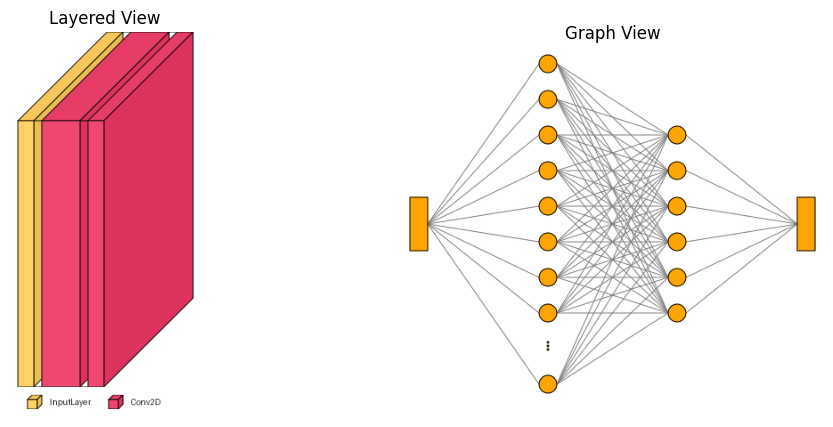

In [37]:
def build_cnn(num_classes):
    inputs = tf.keras.layers.Input(shape=(224, 224, NUM_CHANNELS))

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    )(inputs)

    outputs = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(3, 3),
        activation='softmax',
        padding='same'
    )(x)

    return tf.keras.Model(inputs, outputs)

model = build_cnn(num_classes=NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)


# ---- visualkeras visualization ----
def visualize_model(model, figsize, scale_xy, scale_z):
    # Hack to make visualkeras work.
    for layer in model.layers:
        if not hasattr(layer, 'output_shape'):
            layer.output_shape = layer.output.shape

    fig, ax = plt.subplots(1, 2, figsize=figsize)

    # Generate the first view
    img1 = visualkeras.layered_view(model, legend=True, scale_xy=scale_xy, scale_z=scale_z)
    ax[0].imshow(img1)
    ax[0].set_title("Layered View")
    ax[0].axis("off")  # Hide axes ticks

    # Generate the second view
    img2 = visualkeras.graph_view(model, node_size=20, node_spacing=20, layer_spacing=125)
    ax[1].imshow(img2)
    ax[1].set_title("Graph View")
    ax[1].axis("off")

    plt.show()


visualize_model(model, (12, 5), 1.5, 1.5)

### Step 2.3 Training the model

In [13]:
EPOCHS = 1

class ProgressLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open('result/progress.log', 'a') as f:
            f.write(f"Epoch {epoch+1}/{self.params['epochs']} | "
                    f"Loss: {logs['loss']:.4f}, Acc: {logs['sparse_categorical_accuracy']:.4f} | "
                    f"Val Loss: {logs['val_loss']:.4f}, Val Acc: {logs['val_sparse_categorical_accuracy']:.4f}\n")
            f.flush()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_step_2_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, ProgressLogger()]
)

2026-02-19 14:29:07.084291: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 262144


   2258/Unknown 103s 46ms/step - accuracy: 0.3604 - loss: 1.4652

2026-02-19 14:30:50.105201: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/williamnorland/Documents/Chalmers/Design of AI systems/Design-Of-AI-Systems/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from None to 0.53075, saving model to best_step_2_model.keras

Epoch 1: finished saving model to best_step_2_model.keras


2026-02-19 14:31:04.711261: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


FileNotFoundError: [Errno 2] No such file or directory: 'result/progress.log'

### Step 2.3.1 Visualizing the training history

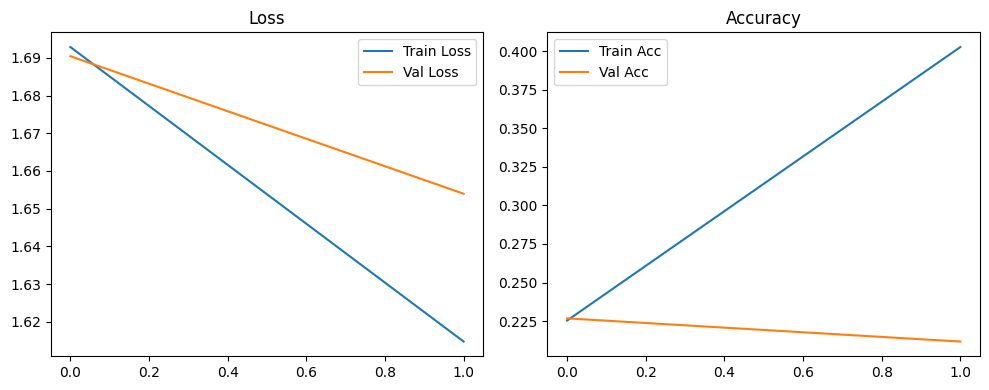

In [ ]:
# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

### Step 2.4 Define Evaluation

In [ ]:
best_model = tf.keras.models.load_model('best_step_2_model.keras')
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1904 - loss: 1.7157
Test Loss: 1.7157, Test Acc: 0.1904


### Step 3 Creating the advanced model 

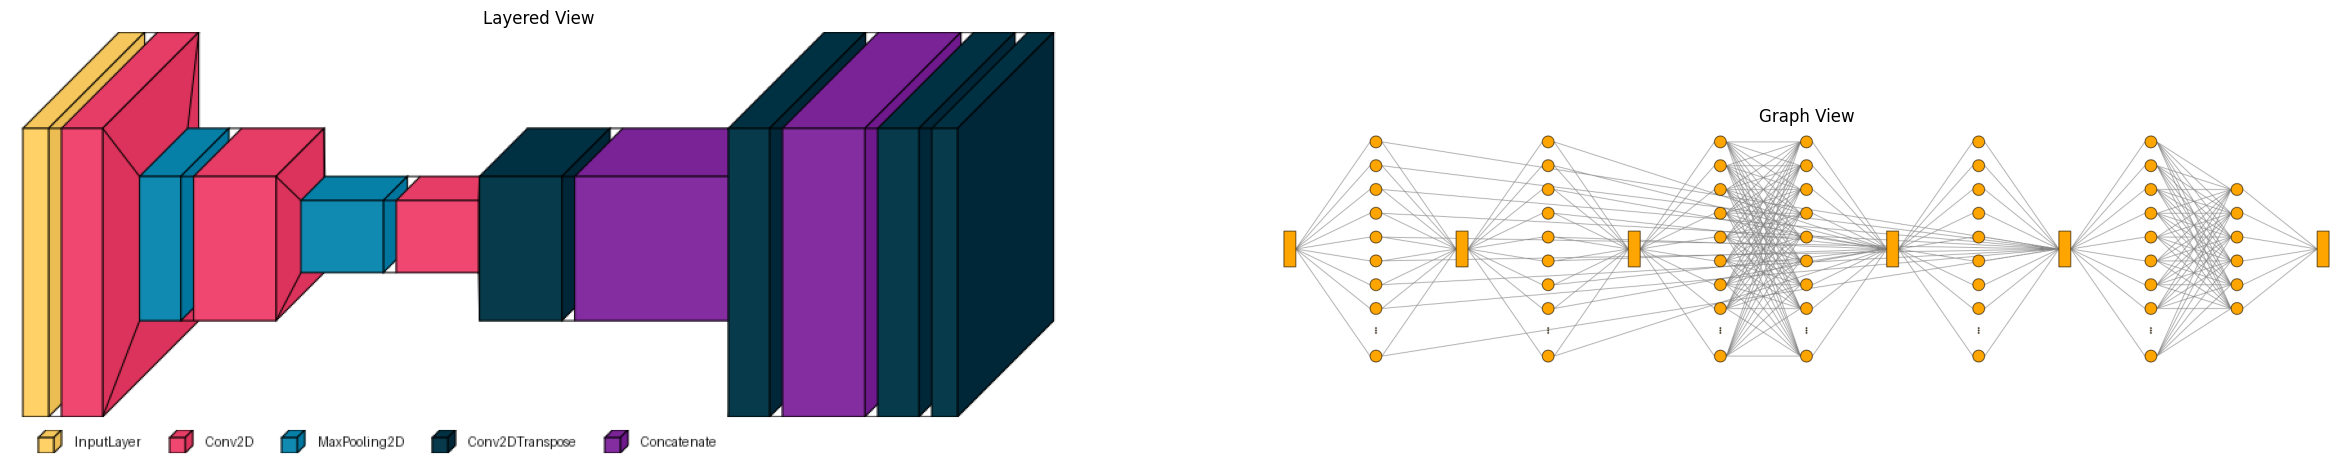

In [ ]:
def build_unet(num_classes):
    inputs = tf.keras.layers.Input(shape=(224, 224, NUM_CHANNELS))

    # ENCODER

    # Level 1 tensor
    x1 = tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), activation="relu", padding="same"
    )(inputs)

    # Level 2 tensor
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x2 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), activation="relu", padding="same"
    )(x2)

    # Level 3 tensor
    x3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), activation="relu", padding="same"
    )(x3)

    # DECODER
    x3 = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same"
    )(x3)
    x32 = tf.keras.layers.Concatenate(axis=-1)([x3, x2])

    x32 = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same"
    )(x32)
    x321 = tf.keras.layers.Concatenate(axis=-1)([x32, x1])

    x321 = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=(3, 3), activation="relu", padding="same"
    )(x321)
    outputs = tf.keras.layers.Conv2DTranspose(
        filters=num_classes, kernel_size=(3, 3), activation="softmax", padding="same"
    )(x321)

    return tf.keras.Model(inputs, outputs)


model = build_unet(num_classes=NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

visualize_model(model, (30, 10), 1, 1)